In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import random

import pandas as pd

from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn

from torch.optim import AdamW

import torch_geometric.transforms as T

from torch_geometric.data import Batch

from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn import global_add_pool
from torch_geometric.nn import GraphConv
from torch.utils.data import DataLoader

from pathlib import Path

from tqdm import tqdm

In [3]:
import sys
import os
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
parent_parent_dir = os.path.dirname(parent_dir)

sys.path.append(parent_dir)
sys.path.append(parent_parent_dir)

from DataPipeline.dataset import ZincSubgraphDatasetStep, custom_collate_GNN3
from Model.GNN3 import ModelWithEdgeFeatures
from Model.metrics import pseudo_accuracy_metric, pseudo_recall_for_each_class, pseudo_precision_for_each_class
from DataPipeline.preprocessing import plot_graph


In [4]:
datapath = Path('..') / '../DataPipeline/data/preprocessed_graph_no_I_Br_P.pt'
dataset = ZincSubgraphDatasetStep(data_path = datapath, GNN_type=3)

Dataset encoded with size 7


In [5]:
loader = DataLoader(dataset, batch_size=128, shuffle=True, collate_fn=custom_collate_GNN3)

In [6]:
encoding_size = 7

model = ModelWithEdgeFeatures(in_channels=encoding_size, hidden_channels_list=[5], edge_channels=4, use_dropout=False)

In [26]:
y_list = []

for batch in tqdm(loader):
    y_list.append(torch.sum(batch[1], dim=0))



y_tensor = torch.stack(y_list, dim=0)
sum = torch.sum(y_list, dim=0)
print(sum/len(dataset))

    

  0%|          | 0/1845 [00:00<?, ?it/s]c:\Users\goupi\OneDrive - CentraleSupelec\VSCODE\Siena\MolecularGen\Molgen\MolGen\DataPipeline\dataset.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  subgraph.cycle_label = torch.tensor(node_features_label, dtype=torch.float)
c:\Users\goupi\OneDrive - CentraleSupelec\VSCODE\Siena\MolecularGen\Molgen\MolGen\DataPipeline\dataset.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  subgraph.mask = torch.tensor(mask, dtype=torch.bool)
100%|██████████| 1845/1845 [04:24<00:00,  6.96it/s]


TypeError: sum() received an invalid combination of arguments - got (list, dim=int), but expected one of:
 * (Tensor input, *, torch.dtype dtype)
 * (Tensor input, tuple of ints dim, bool keepdim, *, torch.dtype dtype, Tensor out)
 * (Tensor input, tuple of names dim, bool keepdim, *, torch.dtype dtype, Tensor out)


In [30]:
torch.sum(y_tensor, dim=0) / len(dataset)

tensor([8.6978e-02, 4.0988e-02, 7.3692e-04, 0.0000e+00, 1.2955e+01])

In [31]:
torch.sum(y_tensor, dim=0)

tensor([2.0537e+04, 9.6780e+03, 1.7400e+02, 0.0000e+00, 3.0589e+06])

In [ ]:
for batch in loader:
    graph_batch = batch
    break

In [ ]:
graph_batch[0].to_data_list()[12].terminal_node_info

(20,
 [(1,
   tensor([1., 0., 0., 0., 0., 0., 0.]),
   tensor([1., 0., 0., 0.]),
   [(2, tensor([1., 0., 0., 0.]))])])

In [ ]:
graph_batch[1][12]

tensor([[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]])

In [ ]:
graph_batch[2][12]

tensor([False, False, False,  True,  True,  True,  True,  True])

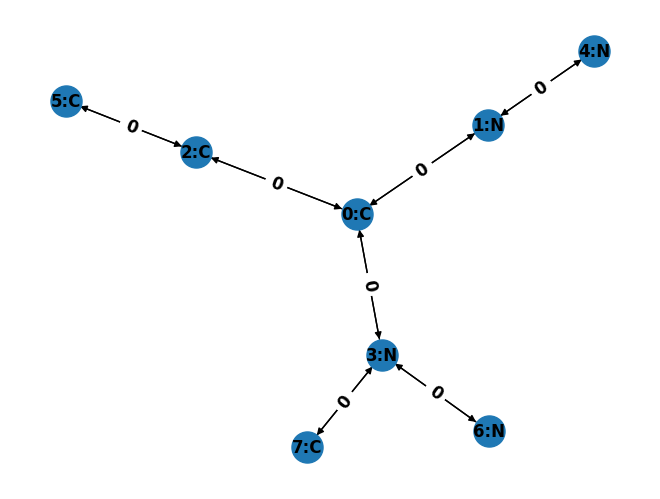

In [ ]:
plot_graph(torch_geometric_to_networkx(graph_batch[0].to_data_list()[12]), encoding_type='reduced', atom_conversion_type='onehot')

In [ ]:
count_cycle_type = {}
weird_example = []
for batch in tqdm(loader):

    if len(batch[1][0]) not in count_cycle_type:
        count_cycle_type[len(batch[1][0])] = 1
    else:
        count_cycle_type[len(batch[1][0])] += 1
    
    if len(batch[1][0]) == 2:
        weird_example.append((batch[0], batch[1]))
        



print(count_cycle_type)

100%|██████████| 236117/236117 [06:43<00:00, 584.80it/s]

{1: 30262, 0: 205846, 2: 9}


In [ ]:
from torch_geometric.utils import to_networkx


def torch_geometric_to_networkx(data):
    """
    Convert a torch_geometric.data.Data object into a networkx.Graph object.

    Args:
    data (torch_geometric.data.Data): A PyTorch Geometric Data object representing the molecule.

    Returns:
    G (networkx.Graph): A NetworkX Graph object representing the molecule.
    """
    # Modify node features to take the argmax, excluding the last element
    if data.x.shape[1] > 1:
        data.x = torch.argmax(data.x[:, :-1], dim=1).unsqueeze(1)

    # Modify edge features to take the argmax
    if data.edge_attr.shape[1] > 1:
        data.edge_attr = torch.argmax(data.edge_attr, dim=1).unsqueeze(1)

    G = to_networkx(data, node_attrs=['x'], edge_attrs=['edge_attr'])

    for i in G.nodes:
        x_attr = G.nodes[i]['x']
        atomic_num = int(x_attr.item()) if hasattr(x_attr, 'item') else int(x_attr)
        G.nodes[i]['atomic_num'] = atomic_num
        del G.nodes[i]['x']

    for i, j in G.edges:
        edge_attr = G.edges[i, j]['edge_attr']
        bond_type = edge_attr.item() if hasattr(edge_attr, 'item') else edge_attr
        G.edges[i, j]['bond_type'] = bond_type
        del G.edges[i, j]['edge_attr']

    return G

In [ ]:
example = weird_example[5][0][0]

In [ ]:
example.edge_attr = torch.cat([example.edge_attr, torch.Tensor([[0., 1., 0., 0.]])], dim=0)

In [ ]:
G = torch_geometric_to_networkx(example)

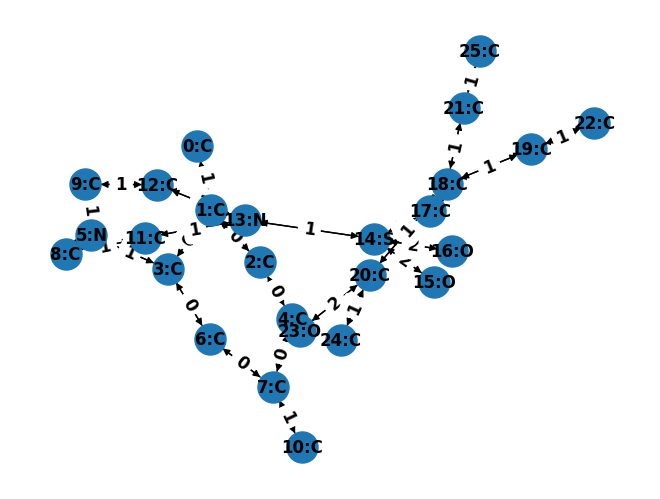

In [ ]:
plot_graph(G, atom_conversion_type='onehot', encoding_type='reduced')

In [ ]:
weird_example[0][0][0].edge_attr

tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])

In [ ]:
torch_geometric_to_networkx(weird_example[0][0][0], atom_conversion_type='onehot', encoding_type='reduced')

TypeError: torch_geometric_to_networkx() got an unexpected keyword argument 'atom_conversion_type'

In [ ]:
from DataPipeline.preprocessing import plot_graph

for example in weird_example:
    plot_graph(torch_geometric_to_networkx(example[0][0]), atom_conversion_type='reduced')

IndexError: list index out of range